In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import torch

In [2]:
# load tensorqtl scripts
import sys
sys.path.insert(0, '/Users/yanyul/Documents/repo/github/tensorqtl/tensorqtl')

import tensorqtl
from tensorqtl import cis
from tensorqtl import mixqtl

In [3]:
# the code has been pushed to my fork tensorqtl
# # load mixQTL.py by Francois
# sys.path.insert(0, '/Users/yanyul/Desktop/tmp/tensorqtl_test/')
# import mixqtl
# from importlib import reload 
# mixqtl = reload(mixqtl)

# Data pointers

In [4]:
datadir = '/Users/yanyul/Desktop/tmp/GEUVADIS-mixqtl'

# genotypes
hap1_file = f'{datadir}/tempo-GEUVADIS.chr22.PH1PH2_465.IMPFRQFILT_BIALLELIC_PH.annotv2.genotypes.hap1.parquet'
hap2_file = f'{datadir}/tempo-GEUVADIS.chr22.PH1PH2_465.IMPFRQFILT_BIALLELIC_PH.annotv2.genotypes.hap2.parquet'

# total count matrix
trc_file = f'{datadir}/rmdup-GD660.GeneQuantCount.txt.gz'
trc_file_rename = f'{datadir}/rmdup-GD660.GeneQuantCount.bed.gz'

# library size
lib_file = f'{datadir}/libsize-GD660.GeneQuantCount.txt.gz'

# covariate matrix
covar_file = f'{datadir}/geuvadis.covariate.txt.gz'

# output prefix
output_prefix = 'geuvadis.mixqtl_run_trc'

# a reference eqtl result
eqtl_reference = '/Users/yanyul/Downloads/EUR373.gene.cis.FDR5.all.rs137.txt.gz'

# Load genotypes

In [5]:
%%bash -s "$trc_file" "$trc_file_rename"
eeee=`zcat < $1 | head -n 1`
echo "#""$eeee" > $2.temp
zcat < $1 | tail -n +2 >> $2.temp
cat $2.temp | gzip > $2
rm $2.temp

In [6]:
# load genotypes
hap1_df = pd.read_parquet(hap1_file)
hap2_df = pd.read_parquet(hap2_file)
variant_df = pd.DataFrame({'chrom':hap1_df.index.map(lambda x: 'chr' + x.split('_')[1]),
                           'pos':  hap1_df.index.map(lambda x: int(x.split('_')[2]))}, index=hap1_df.index)

# Load total counts

In [7]:
def trc_qc(df, pos_df, threshold = 100, min_obs = 50):
    t__ = df >= threshold
    npass = t__.sum(axis = 1)
    df = df.loc[npass >= min_obs, :]
    pos_df = pos_df.loc[npass >= min_obs, :]
    return df, pos_df

In [8]:
phenotype_df, phenotype_pos_df = tensorqtl.read_phenotype_bed(trc_file_rename)
phenotype_df, phenotype_pos_df = trc_qc(phenotype_df, phenotype_pos_df)
libsize_df = pd.read_csv(lib_file, header = 0, sep = '\t', compression = 'gzip')
libsize_df = libsize_df.set_index('indiv')
libsize_s = libsize_df.loc[phenotype_df.columns.tolist(), 'lib_size']

In [9]:
phenotype_df

,HG00096,HG00097,HG00099,HG00100,HG00101,HG00102,HG00103,HG00104,HG00105,HG00106,...,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20816,NA20819,NA20826,NA20828
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000151503.7,2798.000056,5320.000144,3216.000030,3018.000087,3128.000028,2987.999914,2243.999972,2902.000023,2261.999996,3131.564233,...,3939.538491,3257.999897,5902.000245,4329.999840,4859.999933,6781.999825,4952.000011,1864.000045,3445.999921,4814.478882
ENSG00000254681.2,1747.486713,8757.582199,1417.993646,1691.121292,2509.589642,583.771090,2002.207295,2441.343371,768.779140,1575.160178,...,1190.372253,3291.580398,2140.317337,1251.736343,1020.169817,844.461560,800.002270,490.256019,2826.256195,2169.014648
ENSG00000228477.1,7636.555176,10225.760742,5132.418945,9807.343750,4608.492188,2198.073975,8796.096680,6683.120605,5788.375000,9163.044922,...,10762.082031,6897.726563,9818.976563,15364.518555,5515.197754,12477.203125,7978.875000,5158.628906,8617.718750,8126.026367
ENSG00000159733.9,44.881730,80.000000,45.427464,20.000000,30.000002,8.000000,72.000000,44.000001,16.000000,55.999999,...,51.999999,36.000001,78.000001,112.000004,90.000000,78.000000,97.999999,70.000003,79.999999,143.999996
ENSG00000140575.8,12330.000226,19405.999442,13098.000458,10392.000068,11488.000083,12143.999994,9937.999453,12143.999993,10209.999613,14271.999920,...,12894.000122,12398.000233,16904.612201,18940.000061,17696.000006,16524.000595,18105.999861,9541.999982,13460.000058,18749.970189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000184988.2,751.999993,834.000003,428.000000,555.999985,552.000004,805.999985,430.000005,655.999977,418.000023,489.999988,...,819.425904,690.000038,792.000031,730.000000,1038.000031,930.000031,656.000007,784.000038,628.000015,785.999985
ENSG00000101596.8,4674.000000,10074.000000,4638.000000,4468.000000,5762.000000,5976.000000,5964.000000,5792.000000,3383.999756,4948.000000,...,5010.000000,5336.000000,5526.000000,6960.000000,8806.000000,4853.999512,6366.000000,5124.000000,4400.000000,7124.000000
ENSG00000167196.9,2189.439100,2968.000015,1180.000001,1558.000054,1631.999997,1760.000002,1582.000004,1380.000002,1247.999998,2128.528698,...,2448.000074,1519.999982,2622.000034,2387.999928,2451.999865,2803.999975,1879.999962,1058.000016,2223.999902,2848.000067


In [10]:
# compute log(count / libsize)
log_counts_df = np.log(phenotype_df / libsize_s / 2)
log_counts_df = log_counts_df.loc[phenotype_df.index]
log_counts_df[log_counts_df == -np.Inf] = np.NaN
# counts_df = counts_df.loc[phenotype_df.index]

/Users/yanyul/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


# Load fake allele-specific counts

In [11]:
ref_df = phenotype_df.copy()
ref_df.loc[:,:] = 100
alt_df = phenotype_df.copy()
alt_df.loc[:,:] = 200 * np.random.rand(alt_df.shape[0], alt_df.shape[1])

# Load covariates

In [12]:
covariates_df = pd.read_csv(covar_file, sep = '\t', index_col = 0, compression = 'gzip').T
covariates_df = covariates_df.loc[phenotype_df.columns.to_list(), :]

In [13]:
# # load tensorqtl scripts
# import sys
# sys.path.insert(0, '/Users/yanyul/Documents/repo/github/tensorqtl/tensorqtl')

# import tensorqtl
# from tensorqtl import cis
# tensorqtl = reload(tensorqtl)
# cis = reload(cis)

# # load mixQTL.py by Francois
# sys.path.insert(0, '/Users/yanyul/Desktop/tmp/tensorqtl_test/')
# import mixqtl
# from importlib import reload 
# mixqtl = reload(mixqtl)

# Run trcQTL

In [14]:
# map only chr1 for tests:
ix = phenotype_pos_df[phenotype_pos_df['chr']=='chr22'].index
mixqtl.map_nominal(hap1_df, hap2_df, variant_df, 
                   log_counts_df.loc[ix], phenotype_df.loc[ix], ref_df.loc[ix], alt_df.loc[ix],
                   phenotype_pos_df.loc[ix], covariates_df, output_prefix,
                   output_dir=f'{datadir}/', verbose=True)

cis-QTL mapping: nominal associations for all variant-phenotype pairs
  * 462 samples
  * 403 phenotypes
  * 26 covariates
  * 493859 variants
  * checking phenotypes: 403/403
  * Computing associations
    Mapping chromosome chr22
    processing phenotype 403/403
    time elapsed: 7.22 min


/Users/yanyul/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/yanyul/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/yanyul/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


    * writing output
done.


# Results

In [15]:
pval_df = pd.read_parquet(f'{datadir}/{output_prefix}.cis_qtl_pairs.mixQTL.chr22.parquet')

In [16]:
df = pval_df.loc[pval_df['maf_trc'] > 0.01].iloc[:, :10]

In [17]:
# load eqtl results on EUR (by 1000G eQTL paper)
df_ref = pd.read_csv(eqtl_reference, header = 0, compression = 'gzip', sep = '\t')

In [18]:
df_ref.loc[df_ref['CHR_SNP'] == 22]

,SNP_ID,ID,GENE_ID,PROBE_ID,CHR_SNP,CHR_GENE,SNPpos,TSSpos,distance,rvalue,pvalue,log10pvalue
407207,rs4275,-,ENSG00000260065.1,ENSG00000260065.1,22,22,26921725.0,26921002,723.0,0.767814,1.809164e-73,72.742522
407208,rs71311575,-,ENSG00000260065.1,ENSG00000260065.1,22,22,26919156.0,26921002,1846.0,0.750119,2.198221e-68,67.657929
407209,rs6005067,-,ENSG00000260065.1,ENSG00000260065.1,22,22,26923325.0,26921002,2323.0,0.737897,4.089477e-65,64.388332
407210,rs2283824,-,ENSG00000260065.1,ENSG00000260065.1,22,22,26924456.0,26921002,3454.0,0.737108,6.556517e-65,64.183327
407211,rs134157,-,ENSG00000260065.1,ENSG00000260065.1,22,22,26916722.0,26921002,4280.0,-0.652115,1.983698e-46,45.702524
...,...,...,...,...,...,...,...,...,...,...,...,...
419978,rs133379,-,ENSG00000198951.6,ENSG00000198951.6,22,22,42468535.0,42466846,1689.0,0.231022,6.568113e-06,5.182559
419979,rs4253766,-,ENSG00000075234.12,ENSG00000075234.12,22,22,46623905.0,46663858,39953.0,-0.231008,6.576526e-06,5.182003
419980,rs73165152,-,ENSG00000100417.7,ENSG00000100417.7,22,22,42340397.0,41985894,354503.0,-0.231006,6.577641e-06,5.181930
419981,rs133352,-,ENSG00000198951.6,ENSG00000198951.6,22,22,42434022.0,42466846,32824.0,0.231003,6.579434e-06,5.181811


In [19]:
# select a gene and compare
gene = 'ENSG00000198951.6'
df_g_r = df_ref.loc[df_ref['GENE_ID'] == gene]
df_g_r['SNPpos'] = df_g_r['SNPpos'].astype(int)
df_g = df.loc[df['phenotype_id'] == gene]
# df_g['correct_pval'] = 2*stats.t.cdf(-df_g['tstat_trc'].abs(), 1000)
# add snp pos to df_g
df_g = df_g.set_index('variant_id')
df_g = df_g.join(variant_df)
df_join = df_g_r.set_index('SNPpos').join(df_g.set_index('pos'))

/Users/yanyul/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


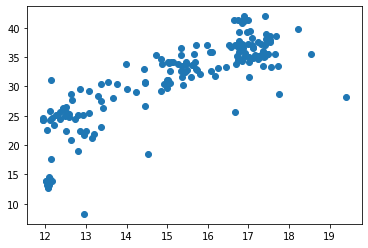

In [20]:
# plot
import matplotlib.pyplot as plt
plt.scatter(-np.log(df_join['pvalue']), -np.log(df_join['pval_trc']))

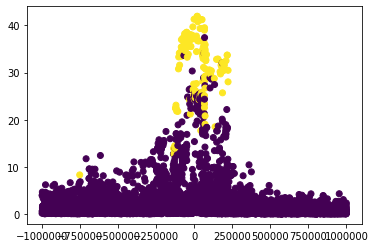

In [21]:
plt.scatter(df_g['tss_distance'], -np.log(df_g['pval_trc']), c = np.isin(df_g['tss_distance'], df_join['tss_distance']).tolist())